In [51]:
import sklearn.datasets as skdata
import numpy as np
import pandas as pd
import plotly.express as px

from dataclasses import dataclass
from haikunator import Haikunator
from sklearn.metrics import accuracy_score

import torch as t
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from torchutils import Hyperparams, Trainer, TrainerArgs
from torchutils.ml_loggers.csv_logger import CsvMLExperiment
from torchutils.ml_loggers.stdout_logger import StdoutMLExperiment
from torchutils.visualizers.csv_metrics_visualizer import analyze, compare

How many samples?

  * `n_samples`
  
  
What kind of features?

  * `n_features`: Total number of features. This is the sum of `n_informative + n_redundant + n_repeated + ` useless features.
  * `n_informative`: Discriminative features.
  * `n_redundant`: Random linear combinations of informative features.
  * `n_repeated`: Number of duplicated features drawn randomly from the informative and redundant features.
  

What kind of classes?

  * `n_classes`: Number of classes
  * `n_clusters_per_class`: Number of clusters per class
  * `weights`: Class frequency
  
  
How hard is the classification problem?

  * `flip_y`: Fraction of samples whose class is assigned randomly. Higher the value, harder the classification.
  * `class_sep`: Smaller the value, harder the classification.
  

By default the features and observations are shuffled. By setting this to `False` we get the features in the following column order:

  1. All the informative features
  2. All the redundant features
  3. All the repeated features
  4. All the useless features

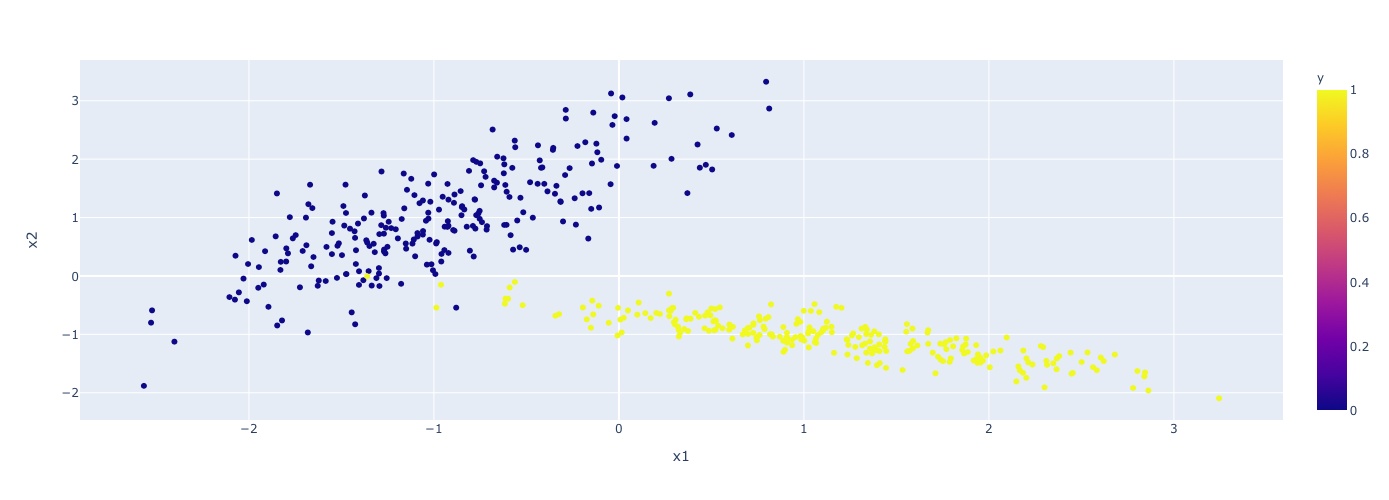

In [45]:
X, y = skdata.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    flip_y=0.0,
    class_sep=1.0,
    shuffle=False
)
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y
fig = px.scatter(df, x="x1", y="x2", color="y")
fig.update_layout(width=700, height=500)

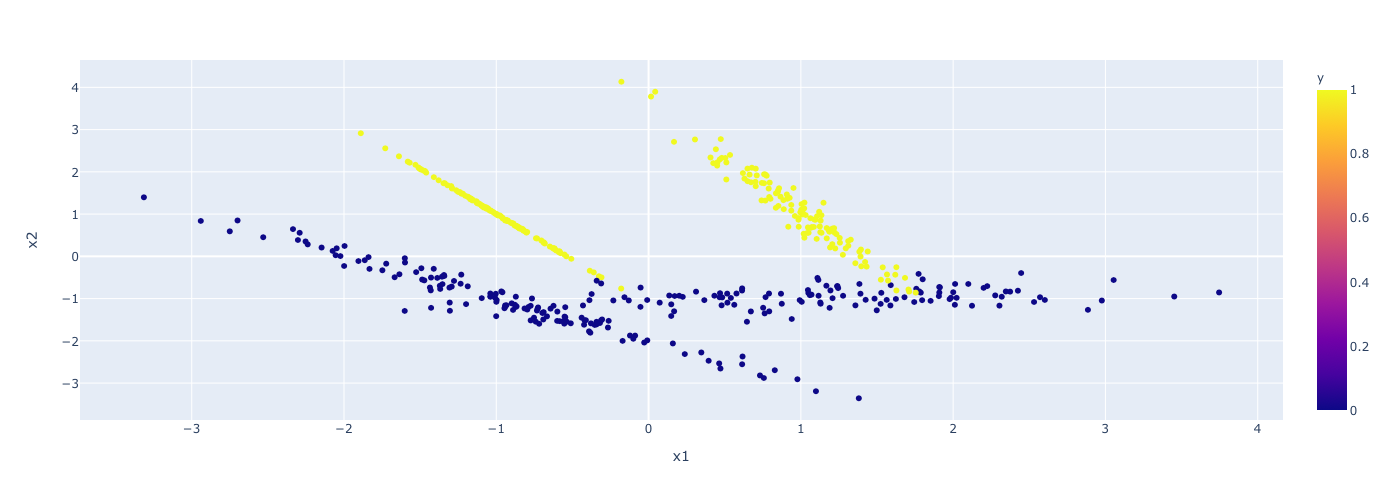

In [47]:
X, y = skdata.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,  # Changed from 1 to 2
    flip_y=0.0,
    class_sep=1.0,
    shuffle=False
)
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y
fig = px.scatter(df, x="x1", y="x2", color="y")
fig.update_layout(width=700, height=500)

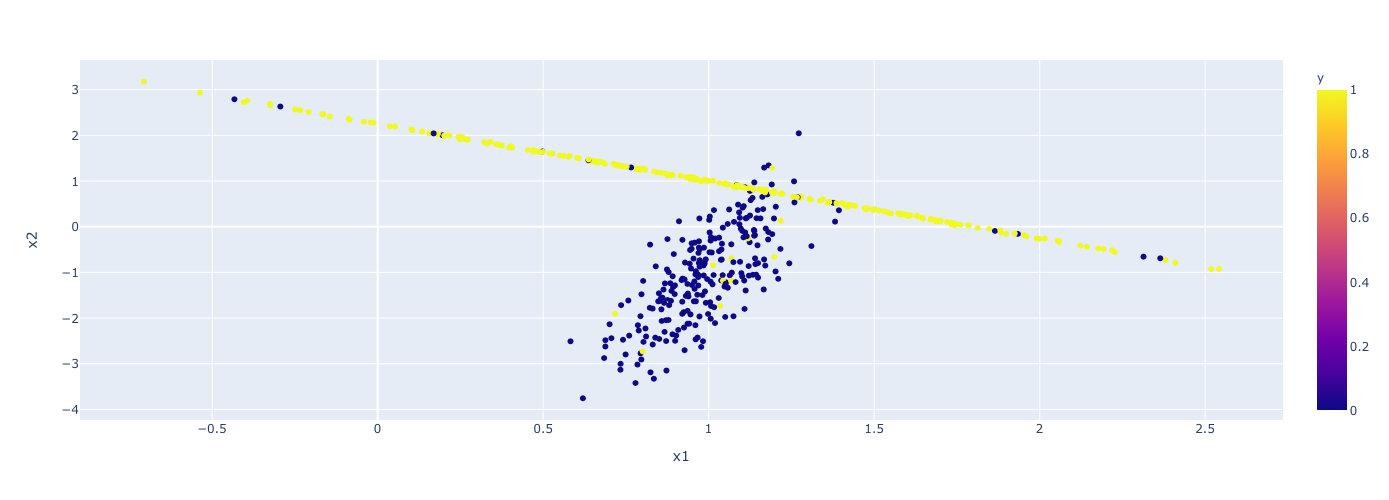

In [48]:
X, y = skdata.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    flip_y=0.1,  # Changed from 0 to 0.1
    class_sep=1.0,
    shuffle=False
)
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y
fig = px.scatter(df, x="x1", y="x2", color="y")
fig.update_layout(width=700, height=500)

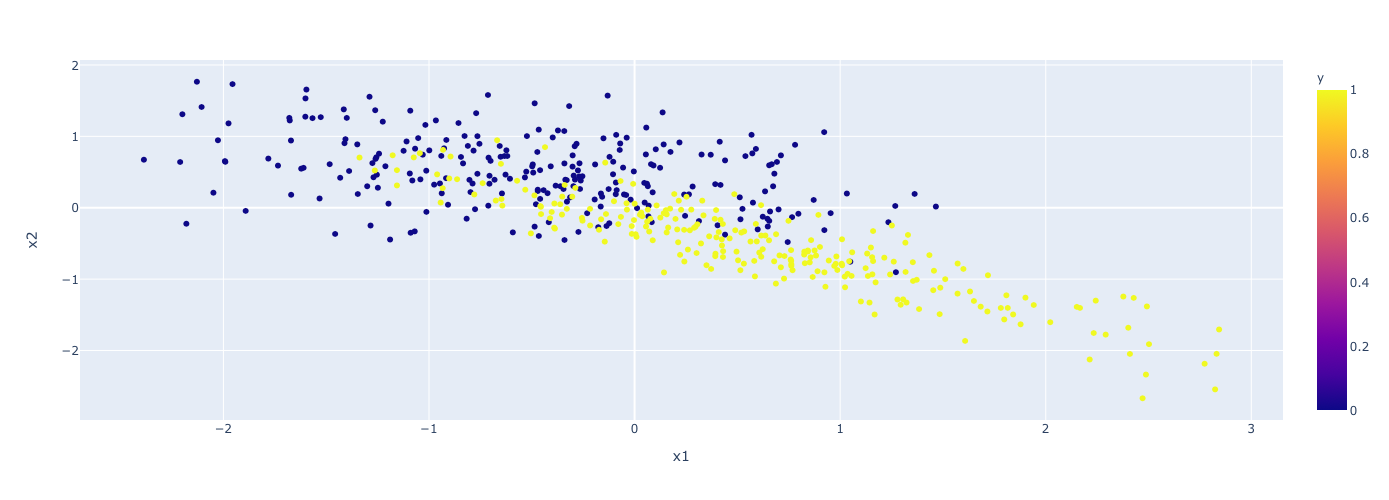

In [49]:
X, y = skdata.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    flip_y=0.0,
    class_sep=0.5,  # Changed from 1 to 0.5
    shuffle=False
)
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y
fig = px.scatter(df, x="x1", y="x2", color="y")
fig.update_layout(width=700, height=500)

Batch size and epochs control the number of weight updates. Smaller batch sizes should have a similar effect as more epochs.

Smaller learning rates will give better results with more weight updates - so with smaller batch sizes or more epochs.

The choice of optimizer should not effect the performance at all.

These assertions are true regardless of the imbalance in the dataset.

Getting rid of strongly correlated features does not effect the performance. The weights will have adjusted appropriately.

# Easy Dataset

In [50]:
X, y = skdata.make_classification(
    n_samples=100_000,
    n_features=10,
    n_informative=10,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.5, 0.5],
    flip_y=0.0,
    class_sep=1.0
)

In [52]:
dataset = TensorDataset(t.from_numpy(X).to(t.float32), t.from_numpy(y).to(t.float32))

In [53]:
h = Haikunator()

In [65]:
class LogisticRegression(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = t.nn.Linear(10, 1)
        
    def forward(self, batch_x):
        x1 = t.sigmoid(self.fc1(batch_x))
        batch_y_hat = t.squeeze(x1, dim=1)
        return batch_y_hat

### Wire Check

In [66]:
tmp_X, tmp_y = dataset[:5]
tmp_y

tensor([1., 1., 0., 1., 1.])

In [67]:
tmp_model = LogisticRegression()
tmp_y_hat = tmp_model(tmp_X)
print(tmp_y_hat.dtype, tmp_y_hat.shape)
tmp_y_hat

torch.float32 torch.Size([5])


tensor([0.2027, 0.1762, 0.3940, 0.5678, 0.1818], grad_fn=<SqueezeBackward1>)

In [68]:
t.nn.BCELoss()(tmp_y_hat, tmp_y)

tensor(1.2207, grad_fn=<BinaryCrossEntropyBackward>)

### Utility Functions

In [69]:
def build_accuracy(cutoff):
    def accuracy(y_true, y_hat):
        y_pred = (y_hat > cutoff).to(t.float32)
        return accuracy_score(y_true, y_pred)

    return accuracy

In [70]:
build_accuracy(0.5)(tmp_y, tmp_y_hat)

0.4

In [73]:
model_factory = {
    "logreg": LogisticRegression
}

In [74]:
optim_factory = {
    "adam": t.optim.Adam
}

In [72]:
@dataclass
class MyHyperparams(Hyperparams):
    batch_size: int
    n_epochs: int
    lr: float
    model_type: str
    optim_type: str

In [84]:
def build_trainer(hparams, trainset, valset):
    run_name = h.haikunate()
    print(f"Starting run {run_name}")
    model = model_factory[hparams.model_type]()
    optim = optim_factory[hparams.optim_type](model.parameters(), lr=hparams.lr)
    loss_fn = t.nn.BCELoss()
    traindl = DataLoader(trainset, batch_size=hparams.batch_size, shuffle=True)
    valdl = DataLoader(valset, batch_size=len(valset))
    return TrainerArgs(
        run_name=run_name,
        model=model,
        optim=optim,
        loss_fn=loss_fn,
        trainloader=traindl,
        valloader=valdl,
        n_epochs=hparams.n_epochs
    )

In [76]:
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

In [77]:
print(len(trainset), len(valset))

90000 10000


### Train Logistic Regression

In [82]:
accuracy = build_accuracy(0.5)
exp = CsvMLExperiment("synth-classification-1", "~/temp/experiments", stdout=False)
trainer = Trainer(exp, trainset, valset, [accuracy])
trainer.metrics_log_frequency = 1

/Users/avilay/temp/experiments/synth-classification-1 already exists. Will add runs to the existing experiment.


In [90]:
hparams = MyHyperparams(
    batch_size=8,
    n_epochs=20,
    lr=0.001,
    model_type="logreg",
    optim_type="adam"
)
trainer.train(hparams, build_trainer)
trainer.final_metrics

Starting run still-base-9892


{'val_loss': 0.2217932790517807, 'val_accuracy': 0.9197}

Evaluation Metrics
  val_loss      : 0.222
  val_accuracy  : 0.919


Hyper Parameters
  batch_size  : 8
  n_epochs    : 10
  lr          : 0.001
  model_type  : logreg
  optim_type  : adam


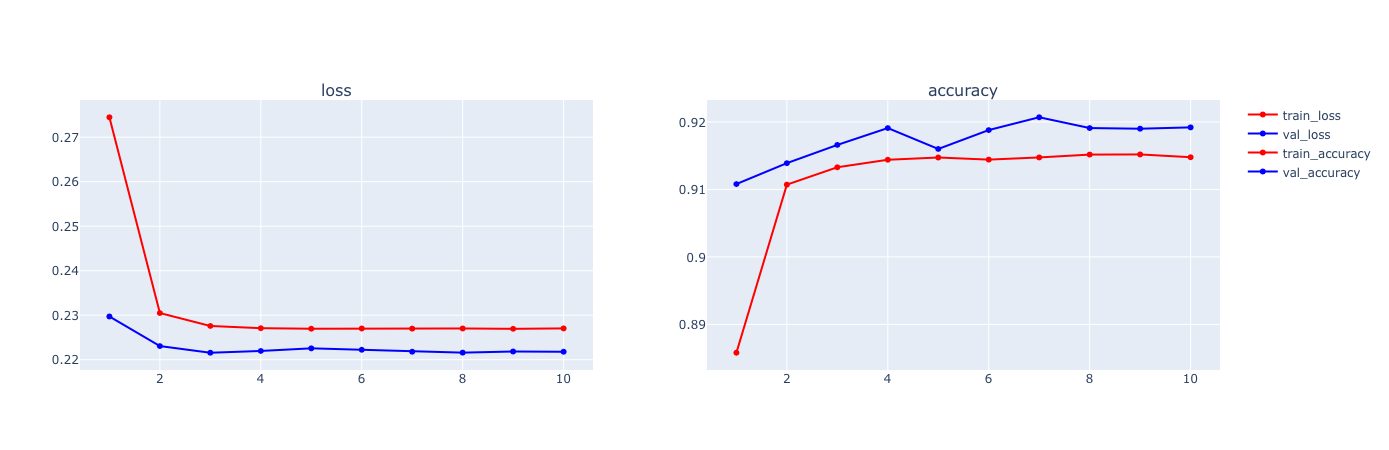

In [89]:
analyze(exproot="~/temp/experiments/synth-classification-1", run_name="long-bar-6042")

In [91]:
compare("~/temp/experiments/synth-classifier-1")

FileNotFoundError: [Errno 2] No such file or directory: '~/temp/experiments/synth-classifier-1'

In [ ]:
X, y = skdata.make_classification(
    n_samples=n_samples,
    n_features=20,
    n_informative=10,
    n_redundant=7,
    n_repeated=3,
    n_classes=2,
    flip_y=0.05,  # larger values make the task hard
    class_sep=0.5,  # larger values makes the task easy
    random_state=10,
)